# Neural Network

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
import pathlib
import sklearn.datasets
from sklearn.model_selection import train_test_split

In [2]:

import copy
from PIL import Image

import glob

import pathlib

data_dir = pathlib.Path('./dataset')


image_count = len(list(data_dir.glob('*/*.*')))
print("Total no of images =", image_count)

images = []
labels = []
classes = set()

image_width = 100
image_height = 100

for filename in data_dir.glob('*/*.*'):
    class_name = str(filename).split("/")[1]
    classes.add(class_name)
    im=copy.deepcopy(Image.open(filename).resize((image_width,image_height)).convert('LA'))
    #print(np.array(im).shape)
    images.append(np.array(im)[...,:1].reshape((image_width*image_height*1,)))
    #print(images[0].shape)
    labels.append(class_name)
    im.close()

classes = sorted(list(classes))
labels = [i for x in labels for i in range(len(classes)) if x == classes[i]]


Total no of images = 9008


(9008, 10000)


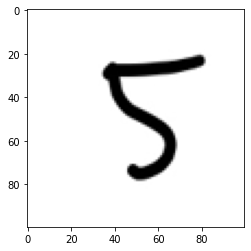

In [3]:
dataX = np.array(images).reshape((len(images), images[0].shape[0]))

#dataX[dataX <  128] = 0
#dataX[dataX >= 128] = 1
dataX = dataX / 255

plt.imshow(dataX[0].reshape(image_width, image_height), cmap="gray")

dataY = np.array(labels).reshape((len(labels),1))
print(dataX.shape)

In [4]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# train is now 60% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#print(x_train, x_val, x_test)

In [5]:
# Add sigmoid FUNCTION from the previous lab

def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz= 1/(1+np.exp(-z))
    
    return gz

In [6]:
# Add costFunctionReg FUNCTION from the previous lab (the function that computes the regularized cost and the gradients)
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m=len(y)
        
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [7]:
# Add gradientDescent FUNCTION from the previous lab (the function that returns the optimal theta vector and J_history)
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        theta = theta - alpha*grad
        
        J_history.append(cost)
    
    return theta , J_history


In [8]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(0,num_labels):
        y10[:,i][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [9]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m=len(X)
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((X.shape[0],1)),X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1= np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1= sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((a1.shape[0],1)),a1,axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2= np.dot(a1,Theta2.T) #Inputs to the output layer neurons
    a2= sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)

In [10]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

In [11]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [12]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [13]:
#It may take very long to finish the training. 
#For 1000 iterations the Training Set Accuracy: 95.28(lambda=0.1; alpha=1)
#You may need more iterations (e.g. 1500) to get better accuracy

input_layer_size  = x_train.shape[1]
hidden_layer_size = 30

alpha=1 #learning rate
num_iters=1000
Lambda=3
num_labels = len(classes)

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())


nnTheta, nnJ_history = gradientDescentnn(x_train,y_train,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1) * hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [14]:
pred3_val = predict(Theta1, Theta2, x_val)
m = len(y_val)
print("Validation Set Accuracy:",sum(np.equal(pred3_val[:,np.newaxis],y_val))[0]/m*100,"%")

pred3_train = predict(Theta1, Theta2, x_train)
m = len(y_train)
print("Training Set Accuracy:",sum(np.equal(pred3_train[:,np.newaxis],y_train))[0]/m*100,"%")

pred3_test = predict(Theta1, Theta2, x_test)
m = len(y_test)
print("Test Set Accuracy:",sum(np.equal(pred3_test[:,np.newaxis],y_test))[0]/m*100,"%")


Validation Set Accuracy: 6.215316315205328 %
Training Set Accuracy: 7.216876387860843 %
Test Set Accuracy: 7.32519422863485 %


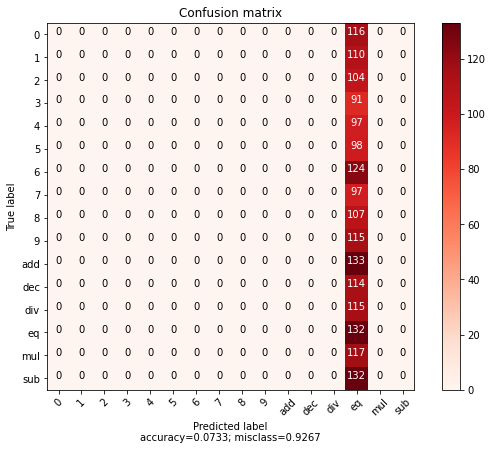

In [15]:
from sklearn.metrics import confusion_matrix
import itertools   
from sklearn.metrics import precision_score, recall_score,f1_score


def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
cm = confusion_matrix(y_test,pred3_test)

plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=classes)



Text(0.5, 1.0, 'Cost function using Gradient Descent')

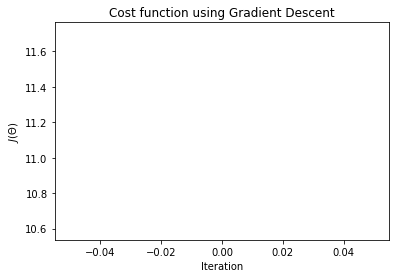

In [16]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")


Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       110
           2       0.00      0.00      0.00       104
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       124
           7       0.00      0.00      0.00        97
           8       0.00      0.00      0.00       107
           9       0.00      0.00      0.00       115
          10       0.00      0.00      0.00       133
          11       0.00      0.00      0.00       114
          12       0.00      0.00      0.00       115
          13       0.07      1.00      0.14       132
          14       0.00      0.00      0.00       117
          15       0.00      0.00      0.00       132

    accuracy                           0.07      1802
  

/home/leand/anaconda3/envs/my-conda-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leand/anaconda3/envs/my-conda-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leand/anaconda3/envs/my-conda-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

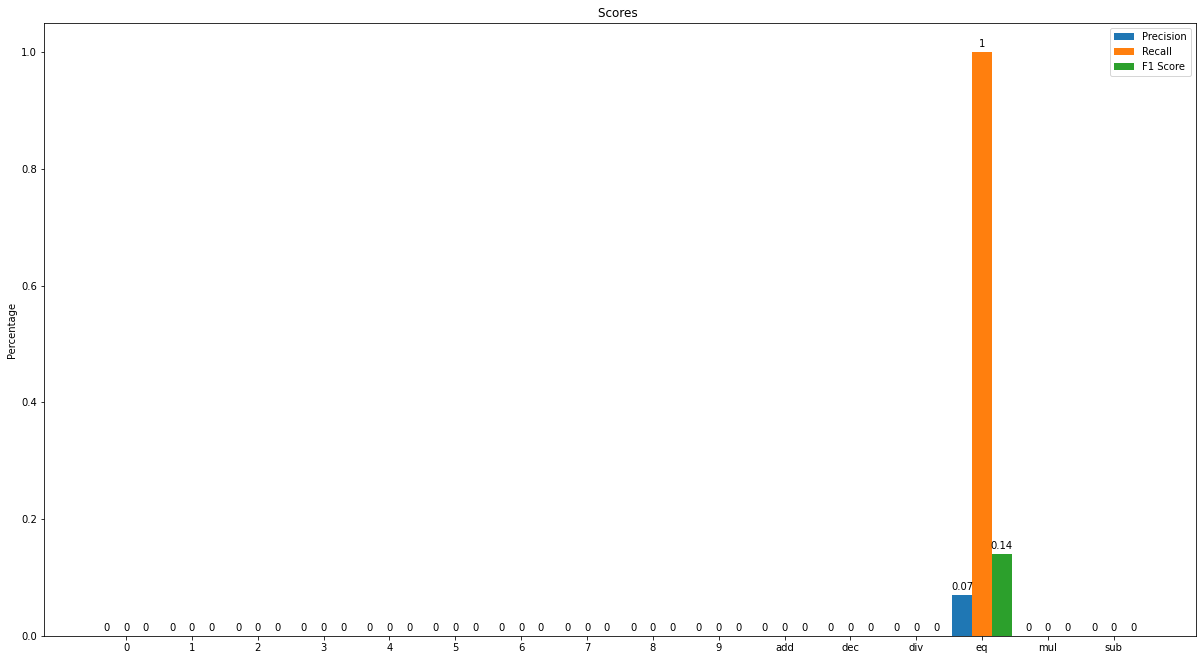

In [17]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
print('\nClassification Report\n')
cr = classification_report(y_test, pred3_test)
print(cr)



labels = classes
precision_score = np.round(precision_score(y_test, pred3_test, average=None),2)
recall_score = np.round(recall_score(y_test, pred3_test, average=None),2)
f1_score = np.round(f1_score(y_test, pred3_test, average=None),2)

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_score, width, label='Precision')
rects2 = ax.bar(x , recall_score, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Scores ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(18.5, 10.5, forward=True)
